In [2]:
#imports
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import util
import pickle
from random import randrange
import scipy
import math

In [63]:
#generate random chord with 1-6 notes
maxNotes = 6
noise_power = 70 #add white noise

#22 = G2, 53 = D5    D5 freq = 587, G2 freq = 98   (limit freqs?)
lower = 22
upper = 53

#generate numcols random columns from a spectrogram, return (col(s), freqInterval, ans[])
def gencols(numcols):
    cols = []
    
    #pick a random number of notes
    numNotes = randrange(maxNotes) + 1
    notes = []
    
    #generate notes
    for i in range(numNotes):
        rand = randrange(upper - lower + 1) + lower
        while rand in notes:
            rand = randrange(upper - lower + 1) + lower
        notes.append(rand)
    
    #compile sounds
    sound = AudioSegment.from_file("pianomonoindexed/" + str(notes[0]) + ".mp3", format="mp3")
    for i in range(1, numNotes):
        soundnew = AudioSegment.from_file("pianomonoindexed/" + str(notes[i]) + ".mp3", format="mp3")
        #add a randomized decibel offset between -10 and 5
        offset = randrange(15) - 10
        soundnew += offset
        sound = sound.overlay(soundnew, position=0)

    data = np.array(sound.get_array_of_samples())
    noise = np.int_(np.round(np.random.normal(scale=100, size=len(data))))
    data += noise
    
    #generate spectrum
    #plt.specgram for visual spectrum (uses more time)
    #spectrum, freqs, times, dot = plt.specgram(np.array(sound.get_array_of_samples()), Fs=sound.frame_rate, NFFT=8192)
    #plt.show()
    #scipy.signal.spectrogram for without visual graph (save time)
    freqs, times, spectrum = scipy.signal.spectrogram(np.array(sound.get_array_of_samples()), fs=sound.frame_rate, nperseg=8192)
    #with the current settings, spectrum = [4097, 2] (dimensions)
    
    #generate the answer array
    ans = []
    for i in range(upper - lower + 1):
        if (i + lower) in notes:
            ans.append(1)
        else:
            ans.append(0)
    
    if numcols == 1:
        randbool = randrange(1)
        return ([spectrum[:,randbool]], freqs[1], ans)
    else:
        return (np.transpose(spectrum), freqs[1], ans)

([array([3.63056258e+00, 1.83810548e+02, 2.17065876e+02, ...,
       1.54623990e-07, 2.93538277e-06, 7.48791590e-07])], 5.38330078125, [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


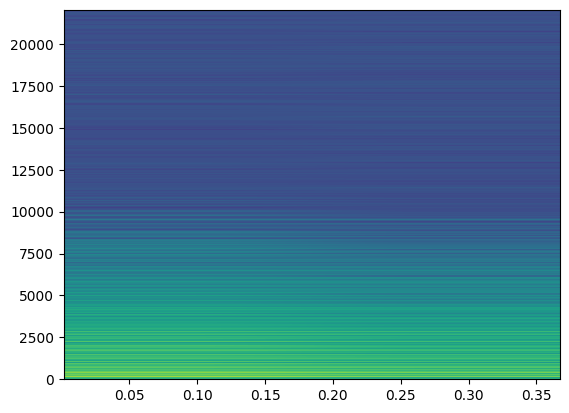

In [64]:
print(gencols(1))

0 train
0 test
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


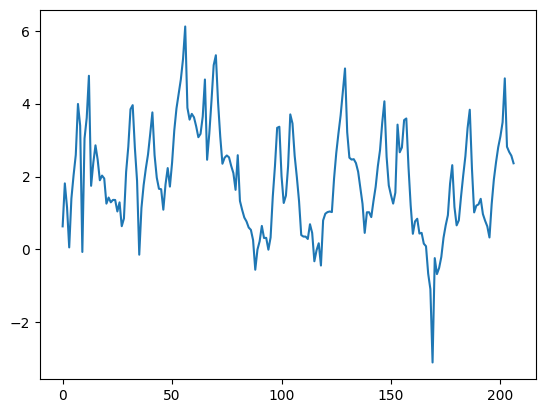

In [62]:
#create and serialize data
xtrain = []
ytrain = []
xtest = []
ytest = []

#data will have 1-6 note chords, only containing notes from G2 to D5 (inclusive)
numtrain = 1
numtest = 1

minfreq = 95
maxfreq = 1200
numcolsPerSample = 1


def normalize(arr):
    ##TODO LOGARIZE + NORMALIZE DATA
    return np.log10(arr)



for i in range(math.ceil(numtrain/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtrain.append(normalize(col[lowerindex:upperindex + 1]))
    ytrain.append(ans)
    print(str(i) + " train")
    
for i in range(math.ceil(numtest/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtest.append(normalize(col[lowerindex:upperindex + 1]))
    ytest.append(ans)
    print(str(i) + " test")

    
folder = "trainingdata/"
pickle.dump(xtrain, open(folder + "xtrain.p", "wb"))
plt.plot(xtrain[0])
print(ytrain[0])


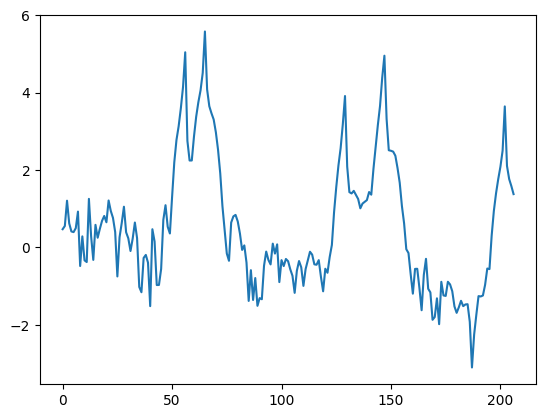

In [12]:
data = pickle.load(open(folder + "xtrain.p", "rb"))
plt.plot(data[0])